In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install -q graphviz

This notebook contains model for visualizing corroded area in the given image and to find area of corrosion on the image

Importing necessary libraries

In [13]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix
import xgboost as xgb

In [3]:
# Load the CSV data
df_train = pd.read_csv('/content/drive/MyDrive/Major_Project/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Major_Project/data/test.csv')

In [4]:
# Separate the target variable and input features and Split the data into training and testing sets
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [5]:
num_rows_train = len(df_train)
print(f"The training dataset has {num_rows_train} pixels and their rgb valus")
num_rows_test = len(df_test)
print(f"The testing dataset has {num_rows_test} pixels and their rgb valus")

The training dataset has 344202 pixels and their rgb valus
The testing dataset has 60740 pixels and their rgb valus


Functions for Visualization

In [6]:
#build data generator function
def batch_generator(X, y, batch_size=32, shuffle=True):
    while True:
        # Shuffle the data if specified
        if shuffle:
            X = X.sample(frac=1).reset_index(drop=True)
            y = y[X.index]
        
        # Loop over the data in batches
        for i in range(0, len(X), batch_size):
            X_batch = X.iloc[i:i+batch_size].values.astype(np.float32)
            y_batch = y.iloc[i:i+batch_size].values.astype(np.int32)
            
            yield X_batch, y_batch

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

In [8]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 100

def learning_rate_schedule(iteration):
    if iteration < 50:
        return 0.1
    else:
        return 0.01

callbacks = [    xgb.callback.LearningRateScheduler(learning_rate_schedule),    xgb.callback.EarlyStopping(rounds=5)]


model = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=[(dval, 'val')], 
                  verbose_eval=True, callbacks=callbacks)
model.save_model('trained_model.model')

[0]	val-logloss:0.63682
[1]	val-logloss:0.59005
[2]	val-logloss:0.55113
[3]	val-logloss:0.51835
[4]	val-logloss:0.48973
[5]	val-logloss:0.46517
[6]	val-logloss:0.44431
[7]	val-logloss:0.42638
[8]	val-logloss:0.41012
[9]	val-logloss:0.39672
[10]	val-logloss:0.38477
[11]	val-logloss:0.37372
[12]	val-logloss:0.36425
[13]	val-logloss:0.35604
[14]	val-logloss:0.34907
[15]	val-logloss:0.34252
[16]	val-logloss:0.33715
[17]	val-logloss:0.33145
[18]	val-logloss:0.32616
[19]	val-logloss:0.32118
[20]	val-logloss:0.31723
[21]	val-logloss:0.31361
[22]	val-logloss:0.31001
[23]	val-logloss:0.30664
[24]	val-logloss:0.30342
[25]	val-logloss:0.30139
[26]	val-logloss:0.29924
[27]	val-logloss:0.29734
[28]	val-logloss:0.29584
[29]	val-logloss:0.29436
[30]	val-logloss:0.29311
[31]	val-logloss:0.29194
[32]	val-logloss:0.28966
[33]	val-logloss:0.28849
[34]	val-logloss:0.28763
[35]	val-logloss:0.28681
[36]	val-logloss:0.28563
[37]	val-logloss:0.28494
[38]	val-logloss:0.28348
[39]	val-logloss:0.28294
[40]	val-l

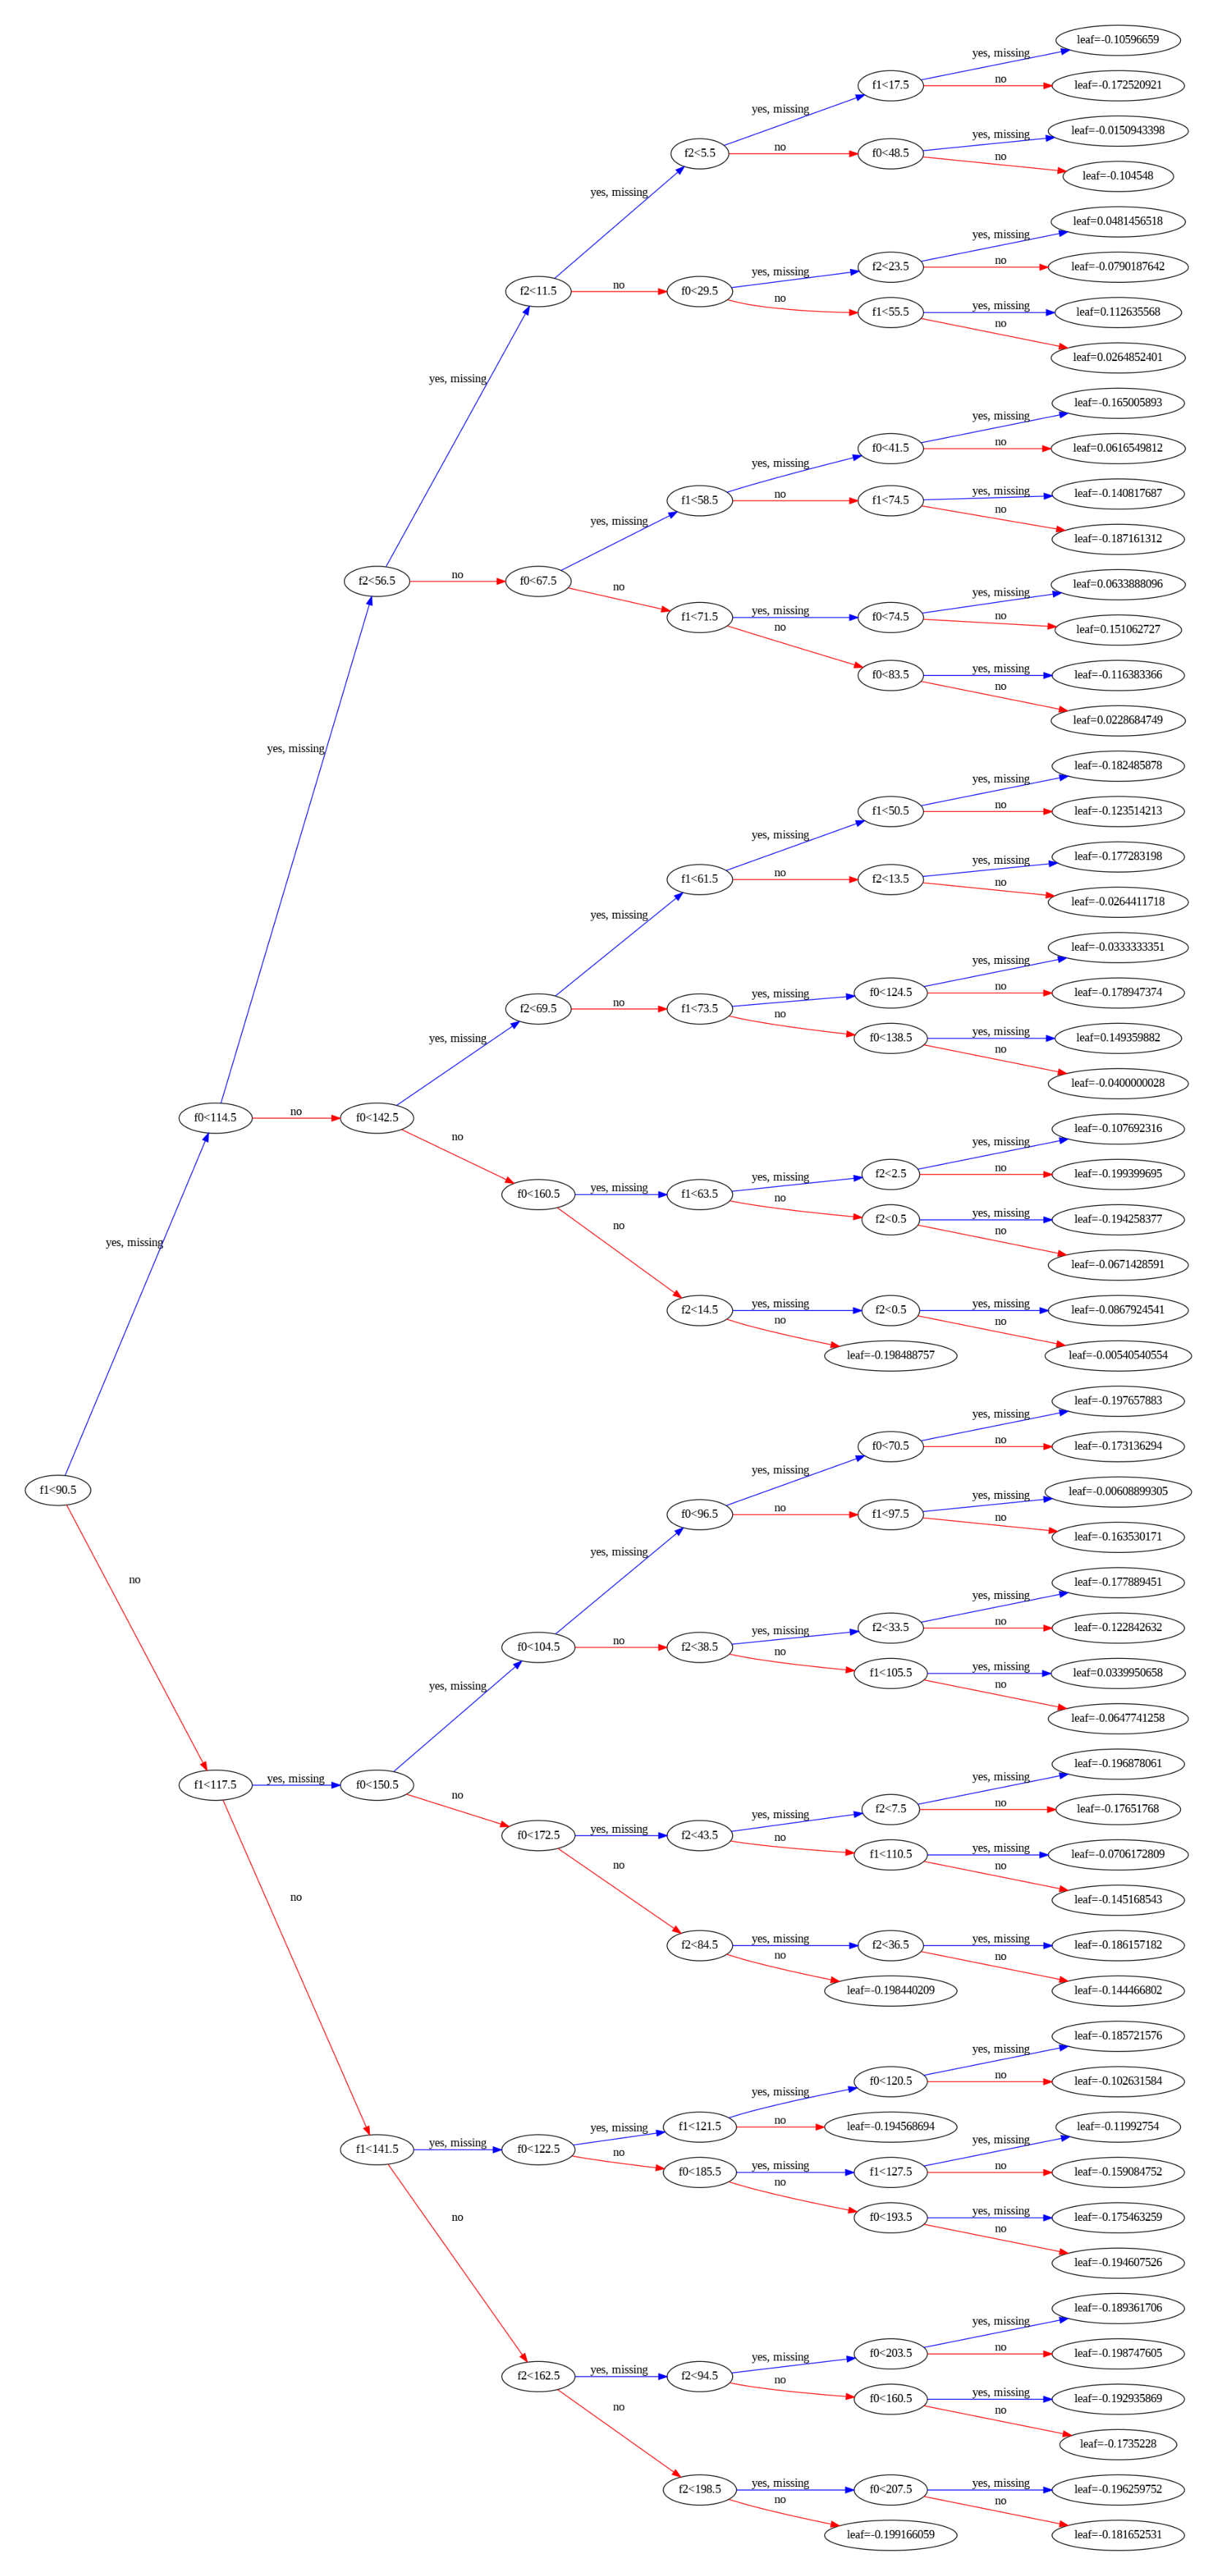

In [53]:
import xgboost
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Plot the tree with specified parameters
fig, ax = plt.subplots(figsize=(20, 15), dpi=300)  # Set figure size and DPI
plot_tree(model, num_trees=0, rankdir='LR', ax=ax)  # Use ax parameter to specify axis for the plot
plt.savefig('xgboost_tree.png', dpi=300)  # Save the plot to a file with higher DPI
plt.show()

In [ ]:
y_train_pred = model.predict(dtrain)
y_val_pred = model.predict(dval)
print(y_train_pred)
print(y_val_pred)

[0.01171151 0.0955081  0.7594053  ... 0.00569116 0.8557311  0.81350034]
[0.00225219 0.79568714 0.05885362 ... 0.23468827 0.00663103 0.00418439]


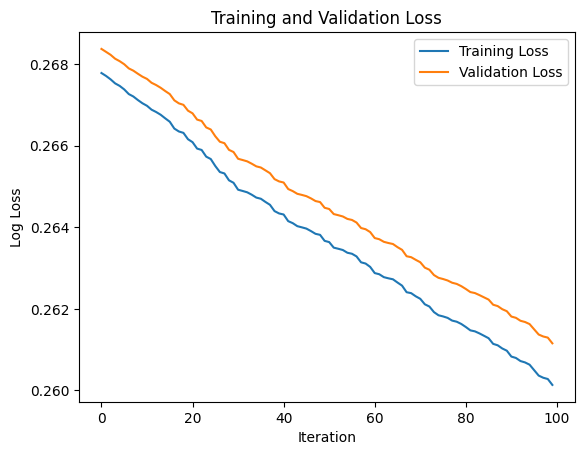

In [ ]:
train_loss = []
val_loss = []
for i in range(num_rounds):
    model.update(dtrain, i)
    train_eval = model.eval(dtrain)
    train_loss.append(float(train_eval.split(':')[1]))
    val_eval = model.eval(dval)
    val_loss.append(float(val_eval.split(':')[1]))


import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Train the XGBoost model

import xgboost as xgb

# Define the model parameters
params = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

# Create the model object
model = xgb.XGBClassifier(**params)

# Train the model
xgboost_model = model.fit(X_train, y_train)

In [44]:
# Evaluate the model performance
#accuracy = model.score(X_test, y_test)
#print(f'Accuracy: {accuracy:.2f}')
from sklearn.metrics import accuracy_score

# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict on test set
y_pred = model.predict(dtest)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.88


0.8901053671386236


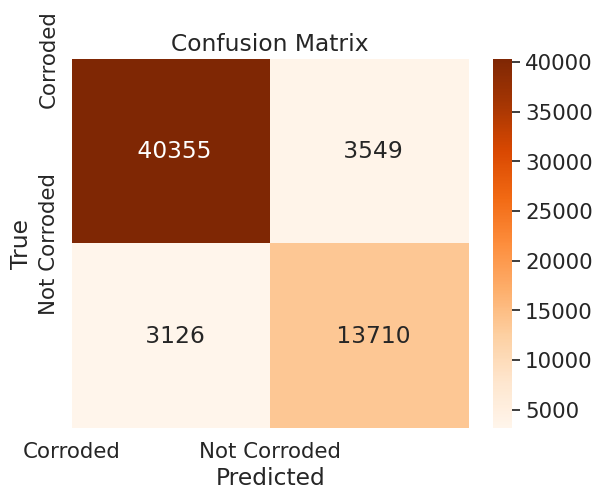

In [ ]:
# Use the trained model to make predictions on test data
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
y_pred_binary = np.round(y_pred)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred_binary)
print(accuracy)

# Plot confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt=" ", cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], labels=['Corroded', 'Not Corroded'])
plt.yticks([0, 1], labels=['Corroded', 'Not Corroded'])
plt.title('Confusion Matrix')
plt.show()

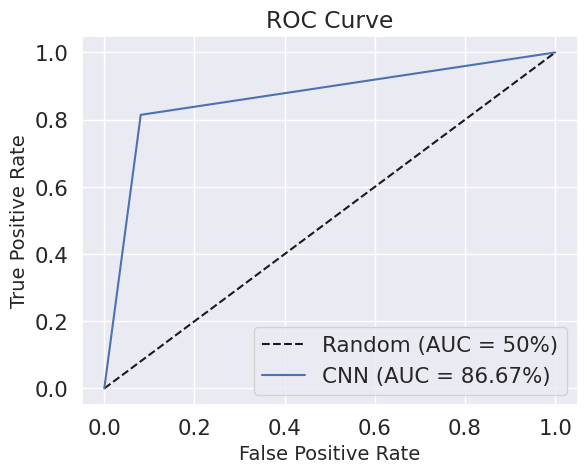

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)
auc = roc_auc_score(y_test, y_pred_binary)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='best')

In [ ]:
# Summary Statistics
    # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TP, FN, FP, TN = cm.ravel() 
    # % true positives and true negatives out of all predicted positives and negatives
accuracy = (TP + TN) / np.sum(cm) 
    # % positive out of all predicted positives
precision = TP / (TP+FP) 
    # % positive out of all supposed to be positives
recall =  TP / (TP+FN) 
    # % negative out of all supposed to be negatives
specificity = TN / (TN+FP)
f1 = 2*precision*recall / (precision + recall)
stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
print(stats_summary)

[Summary Statistics]
Accuracy = 89.01% | Precision = 92.81% | Recall = 91.92% | Specificity = 81.43% | F1 Score = 92.36%


In [ ]:
# Plot training accuracy vs validation accuracy curve
train_auc = model.eval_set([(dtrain, 'train')])['train']['logloss']
val_auc = model.eval_set([(dval, 'val')])['val']['logloss']
plt.plot(train_auc, label='Train')
plt.plot(val_auc, label='Validation')
plt.xlabel('Number of Rounds')
plt.ylabel('Log Loss')
plt.title('Training Log Loss vs Validation Log Loss')
plt.legend()
plt.show()

TypeError: ignored

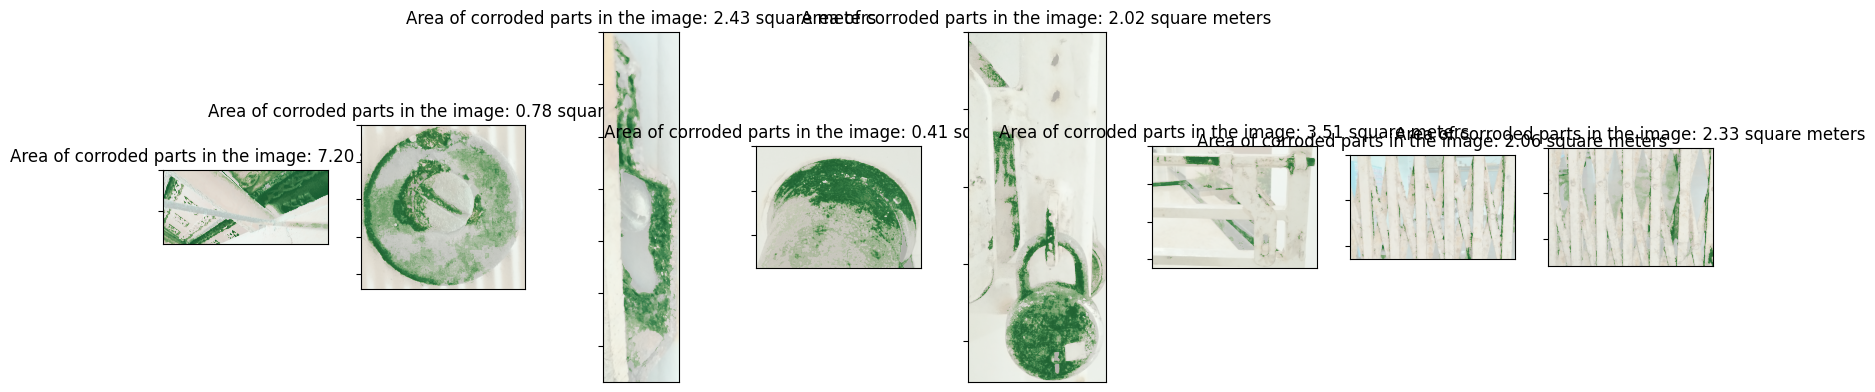

In [ ]:
# Plot CORROSION and NOCORROSION in new training dataset
sample_dir='/content/drive/MyDrive/Major_Project/data/Samples'
plt.figure(figsize = (20,10))
num_imgs_1 = 8
for index in range(num_imgs_1):
    sample_pic_name = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if not f.startswith('.') and f.endswith('.jpg')][index]
    sample_pic_address = sample_pic_name
    # Load pre-trained corrosion detection model
    img = np.array(Image.open(sample_pic_address))

# Reshape the image to match the input features
    X_img = img.reshape(-1, img.shape[-1])
    dimg = xgb.DMatrix(X_img)
    y_pred = model.predict(dimg).reshape(img.shape[:2])
# Predict the corroded parts in the image using the trained model
#y_pred = model.predict(X_img).reshape(img.shape[:2])

# Visualize the corroded parts on the image
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(img)
#ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=1.0, vmin=0.5, vmax=1.0)
#plt.show()
    # Calculate the area of corroded parts in the image
    pixel_size = 1.0 # Set the pixel size in square millimeters
    corroded_pixels = np.count_nonzero(y_pred)
    corroded_area = corroded_pixels * (pixel_size / 1000**2)
    plt.subplot(2, num_imgs_1, index + 1 +num_imgs_1)
    plt.imshow(img)
    plt.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=0.7, vmin=0.5, vmax=1.0)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    plt.title("Area of corroded parts in the image: {:.2f} square meters".format(corroded_area))


In [31]:
import PIL.Image
image = PIL.Image.open('/content/drive/MyDrive/Major_Project/data/Samples/IMG_20230414_181836.jpg')  # Replace 'image.jpg' with the path to your image file
dpi = image.info.get('dpi')  # Get the DPI (dots per inch) or PPI (pixels per inch) of the image
pixel_width = 1 / dpi[0]  # Calculate the width of an individual pixel in inches
pixel_height = 1 / dpi[1]  # Calculate the height of an individual pixel in inches

pixel_area = pixel_width * pixel_height  # Calculate the area of an individual pixel in square inches

print(pixel_area)

1/5184


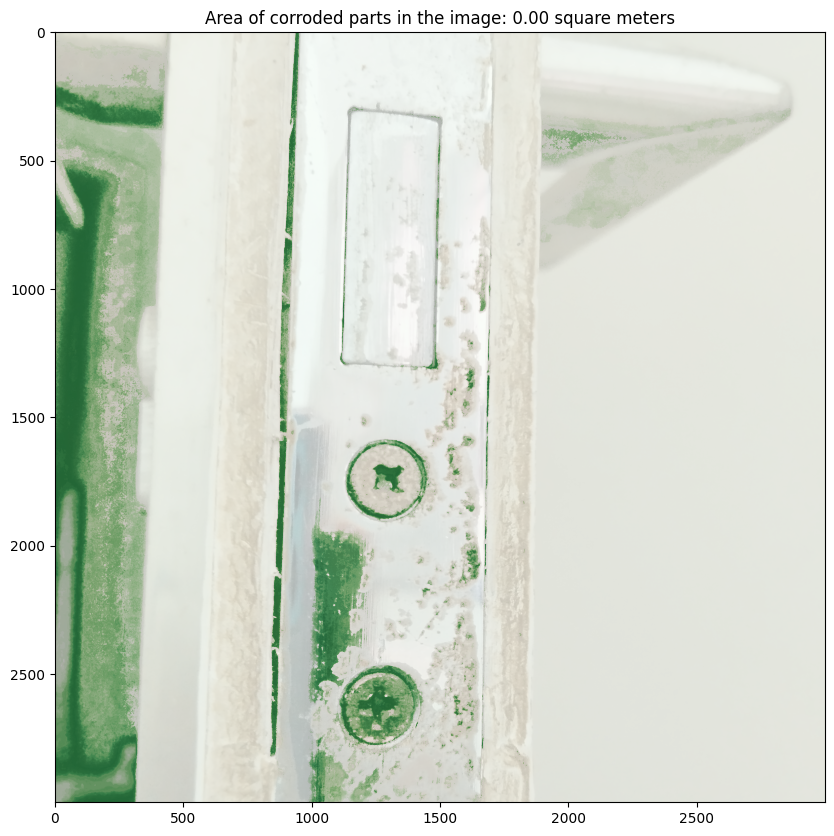

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import fractions
# Load the image data
img = np.array(Image.open('/content/drive/MyDrive/Major_Project/data/Samples/IMG_20230414_181836.jpg'))
image=Image.open('/content/drive/MyDrive/Major_Project/data/Samples/IMG_20230414_181836.jpg')
# Reshape the image to match the input features
X_img = img.reshape(-1, img.shape[-1])
dimg = xgb.DMatrix(X_img)
y_pred = model.predict(dimg).reshape(img.shape[:2])
# Predict the corroded parts in the image using the trained model
#y_pred = model.predict(X_img).reshape(img.shape[:2])

# Visualize the corroded parts on the image
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(img)
#ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=1.0, vmin=0.5, vmax=1.0)
#plt.show()
# Calculate the area of corroded parts in the image
dpi = image.info.get('dpi')  # Get the DPI (dots per inch) or PPI (pixels per inch) of the image
pixel_width = 1 / dpi[0]  # Calculate the width of an individual pixel in inches
pixel_height = 1 / dpi[1]  # Calculate the height of an individual pixel in inches
pixel_area = pixel_width * pixel_height  # Calculate the area of an individual pixel in square inches
pixel_area = round(float(pixel_area), 10)
corroded_pixels = np.count_nonzero(y_pred)
corroded_area = corroded_pixels * (pixel_area * 0.000645 / 1000**2)
corroded_area_round = round(corroded_area, 10)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=0.7, vmin=0.5, vmax=1.0)
plt.title("Area of corroded parts in the image: {:.2f} square meters".format(corroded_area_round))
plt.show()

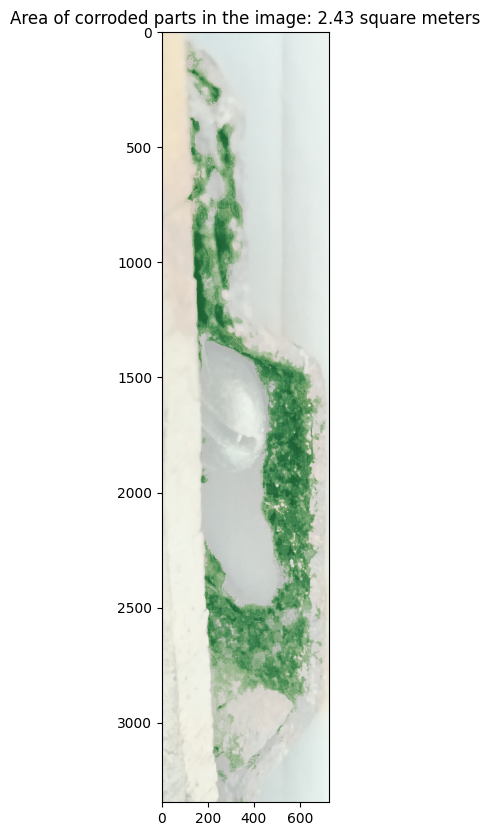

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the image data
img = np.array(Image.open('/content/drive/MyDrive/Major_Project/data/Samples/IMG_20230409_122956.jpg'))

# Reshape the image to match the input features
X_img = img.reshape(-1, img.shape[-1])
dimg = xgb.DMatrix(X_img)
y_pred = model.predict(dimg).reshape(img.shape[:2])
# Predict the corroded parts in the image using the trained model
#y_pred = model.predict(X_img).reshape(img.shape[:2])

# Visualize the corroded parts on the image
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(img)
#ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=1.0, vmin=0.5, vmax=1.0)
#plt.show()
# Calculate the area of corroded parts in the image
pixel_size = 1.0 # Set the pixel size in square millimeters
corroded_pixels = np.count_nonzero(y_pred)
corroded_area = corroded_pixels * (pixel_size / 1000**2)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=0.7, vmin=0.5, vmax=1.0)
plt.title("Area of corroded parts in the image: {:.2f} square meters".format(corroded_area))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the image data
img = np.array(Image.open('/content/drive/MyDrive/Major_Project/data/Samples/IMG_20230409_212058.jpg'))

# Reshape the image to match the input features
X_img = img.reshape(-1, img.shape[-1])
dimg = xgb.DMatrix(X_img)
y_pred = model.predict(dimg).reshape(img.shape[:2])
# Predict the corroded parts in the image using the trained model
#y_pred = model.predict(X_img).reshape(img.shape[:2])

# Visualize the corroded parts on the image
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(img)
#ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=1.0, vmin=0.5, vmax=1.0)
#plt.show()
# Calculate the area of corroded parts in the image
pixel_size = 1.0 # Set the pixel size in square millimeters
corroded_pixels = np.count_nonzero(y_pred)
corroded_area = corroded_pixels * (pixel_size / 1000**2)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.imshow(np.ma.masked_where(y_pred == 0, y_pred), cmap='Greens', alpha=0.7, vmin=0.5, vmax=1.0)
plt.title("Area of corroded parts in the image: {:.2f} square meters".format(corroded_area))
plt.show()

In [ ]:
import pickle
import xgboost as xgb

# Load your trained XGBoost model
model = xgb.Booster()
model.load_model('trained_model.model')

# Specify the file name for the saved model
filename = 'xgboost_color_classifier_model.pkl'

# Save the model using pickle
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f'Saved model as {filename} successfully.')


Saved model as xgboost_color_classifier_model.pkl successfully.


In [ ]:
import cv2
import xgboost as xgb
import numpy as np

# Load the pre-trained XGBoost model
model = xgb.Booster()
model.load_model('trained_model.model')

# Access the mobile camera feed
cap = cv2.VideoCapture(0) # 0 represents the default camera on the mobile device

while True:
    # Capture a video frame from the camera
    ret, frame = cap.read()
    frame = frame.reshape(-1, img.shape[-1])
    frame = xgb.DMatrix(X_img)
    
    # Preprocess the video frame
    # Perform necessary preprocessing such as resizing, color space conversion, and normalization on the frame
    # ...

    # Convert the preprocessed frame into the format expected by the model
    # In this example, assuming the input features are flattened as a 1D array
    X = frame.flatten().astype(np.float32)
    #y_pred = model.predict(dimg).reshape(frame.shape[:2])
    # Perform prediction using the loaded model
    pred_prob = model.predict(xgb.DMatrix(X))
    # Interpret the prediction
    pred_label = 1 if pred_prob > 0.5 else 0  # Assuming binary classification with threshold of 0.5

    # Overlay the prediction on the camera frame
    # Draw a bounding box or add text indicating the predicted label
    # ...
    plt.imshow(np.ma.masked_where(pred_prob == 0, pred_prob), cmap='Greens', alpha=0.7, vmin=0.5, vmax=1.0)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    # Display the processed frame with overlay
    cv2.imshow('Mobile Camera', frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()



AttributeError: ignored